parsing equations from strings sandbox

In [1]:
import re
function_list = ['m']
variable_list = ['x','y']

line = ('(d/dx)^2 m + (d/dy)^2 m')

def lp(line, function_list=function_list, variable_list = variable_list):
    splited = line.split(' ')

    ops_stack = []

    def is_der_operator(string: str):
        if re.findall('\(d\/d..?\)', string):
            return True
        # elif re.findall('\+', string):
        #     return True
        else:
            return False
        
    def apply_ops(ops_stack: list, func: str):
        dif_powers = [0]*len(variable_list)
        for op in ops_stack:
            op = op.replace('(d/d', '')
            op = op.replace(')', '')
            op = op.split('^')

            var_index = variable_list.index(op[0])
            try:
                power = op[1]
            except:
                power = 1
            dif_powers[var_index] = int(power)
        if func[0]=='&':
            f_name = 'u_loc'
        else:
            f_name = 'u_bas'
        func_index = function_list.index(func.replace('&',''))
        return (f_name+'('+str(dif_powers)+', '+str(func_index)+')')

    def is_func(string:str):
        if string[0]=='&' and (string[1:] in function_list):
            return (True, 'local')
        if string in function_list:
            return (True, 'basis')
        else:
            return (False, None)

    res = ''
    for i in range(len(splited)):
        if is_der_operator(splited[i]):
            ops_stack.append(splited[i])
        elif is_func(splited[i])[0]:
            res += (apply_ops(ops_stack, splited[i],))
            ops_stack = []
        else:
            res += splited[i]
    return lambda u_loc, u_bas, x, x_loc: eval(res)

In [12]:
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 5

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

def exact_sol(point):
    x,y = point
    return x**2 * y

def f(point):
    x,y = point
    return 2*x*y + x**2 #x+1#2*x*y + x**2

params = {
    'n_dims': 2,
    'dim_sizes': np.array([3, 3]),
    'area_lims': np.array([[0,1], [0,1]]),
    'power': power,
    'basis': Basis(power),
}
sol = Solution(**params)

connect_points = np.array([
    [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points

colloc_left_operators = [lp('(d/dx) m + (d/dy) m'),]
colloc_right_operators = [lp('f(x)'),]

border_w = 100
border_left_operators = [lp('m * border_w')]
border_right_operators = [lp('exact_sol(x)*border_w')]

connect_left_operators = [lp('m + np.sum(dir(x_loc)) * u_bas(dir(x_loc))'),]
connect_right_operators = [lp('m - np.sum(dir(x_loc)) * u_bas(dir(x_loc))'),]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m'],
        'variable_list': ['x', 'y']}

In [13]:
A, _ = sol.global_solve(**iteration_dict, return_system=True)

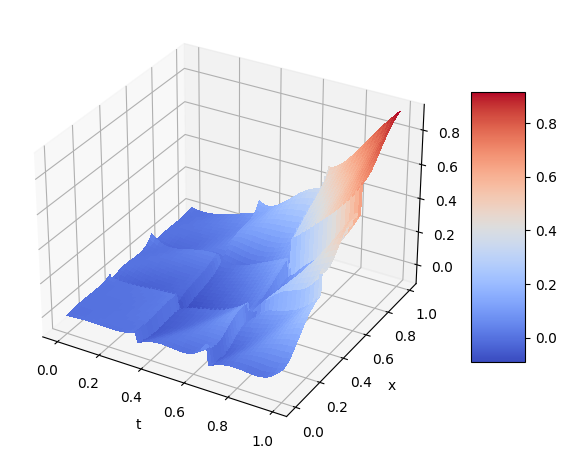

In [14]:
sol.plot2d()